In [7]:
import kagglehub

data_dir = kagglehub.dataset_download("andrewmvd/dog-and-cat-detection")
print("Path to dataset files:", data_dir)

Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1


In [8]:
import os
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import matplotlib.patches as patches
import xml.etree.ElementTree as ET
import tqdm.notebook as tqdm

from PIL import Image
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision.models.resnet import ResNet18_Weights, ResNet50_Weights

In [9]:
class MyDataset(Dataset):
    def __init__(self, annotations_dir, image_dir, transform=None):
        self.annotations_dir = annotations_dir
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = self.filter_images_with_multiple_objects()

    def filter_images_with_multiple_objects(self):
        valid_image_files = []
        for f in os.listdir(self.image_dir):
            if os.path.isfile(os.path.join(self.image_dir, f)):
                img_name = f
                annotation_name = os.path.splitext(img_name)[0] + ".xml"
                annotation_path = os.path.join(self.annotations_dir, annotation_name)

                if self.count_objects_in_annotation(annotation_path) == 1:
                    valid_image_files.append(img_name)
        return valid_image_files

    def count_objects_in_annotation(self, annotation_path):
        try:
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            count = 0
            for obj in root.findall("object"):
                count += 1
            return count
        except FileNotFoundError:
            return 0

    def parse_annotation(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        # Get image size for normalization
        image_width = int(root.find("size/width").text)
        image_height = int(root.find("size/height").text)

        label = None
        bbox = None
        for obj in root.findall("object"):
            name = obj.find("name").text
            if label is None:  # Take the first label
                label = name
            # Get bounding box coordinates
            xmin = int(obj.find("bndbox/xmin").text)
            ymin = int(obj.find("bndbox/ymin").text)
            xmax = int(obj.find("bndbox/xmax").text)
            ymax = int(obj.find("bndbox/ymax").text)

            # Normalize bbox coordinates to [0, 1]
            bbox = [
                xmin / image_width,
                ymin / image_height,
                xmax / image_width,
                ymax / image_height,
            ]

        # Convert label to numerical representation (0 for cat, 1 for dog)
        label_num = 0 if label == "cat" else 1 if label == "dog" else -1
        return label_num, torch.tensor(bbox, dtype=torch.float32)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img1_file = self.image_files[idx]
        img1_path = os.path.join(self.image_dir, img1_file)

        annotation_name = os.path.splitext(img1_file)[0] + ".xml"
        img1_annotations = self.parse_annotation(
            os.path.join(self.annotations_dir, annotation_name)
        )

        idx2 = random.randint(0, len(self.image_files) - 1)
        img2_file = self.image_files[idx2]
        img2_path = os.path.join(self.image_dir, img2_file)

        annotation_name = os.path.splitext(img2_file)[0] + ".xml"
        img2_annotations = self.parse_annotation(
            os.path.join(self.annotations_dir, annotation_name)
        )

        img1 = Image.open(img1_path).convert("RGB")
        img2 = Image.open(img2_path).convert("RGB")

        # Horizontal merge
        merged_image = Image.new(
            "RGB", (img1.width + img2.width, max(img1.height, img2.height))
        )
        merged_image.paste(img1, (0, 0))
        merged_image.paste(img2, (img1.width, 0))
        merged_w = img1.width + img2.width
        merged_h = max(img1.height, img2.height)

        merged_annotations = []

        # No change for objects from img1, already normalized
        merged_annotations.append(
            {"bbox": img1_annotations[1].tolist(), "label": img1_annotations[0]}
        )

        # Adjust bbox coordinates for objects from img2 AND normalize
        new_bbox = [
            (img2_annotations[1][0] * img2.width + img1.width) / merged_w,  # Normalize xmin
            img2_annotations[1][1] * img2.height / merged_h,  # Normalize ymin
            (img2_annotations[1][2] * img2.width + img1.width) / merged_w,  # Normalize xmax
            img2_annotations[1][3] * img2.height / merged_h,  # Normalize ymax
        ]

        merged_annotations.append({"bbox": new_bbox, "label": img2_annotations[0]})

        # Convert merged image to tensor
        if self.transform:
            merged_image = self.transform(merged_image)
        else:
            merged_image = transforms.ToTensor()(merged_image)

        # Convert annotations to 1D tensors, with shape (4,) for bbox and (1,) for label
        annotations = torch.zeros((len(merged_annotations), 5))
        for i, ann in enumerate(merged_annotations):
            annotations[i] = torch.cat((torch.tensor(ann["bbox"]), torch.tensor([ann["label"]])))

        return merged_image, annotations

In [10]:
# Data directory
annotations_dir = os.path.join(data_dir, 'annotations')
image_dir = os.path.join(data_dir, 'images')

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Create dataset and dataloaders
dataset = MyDataset(annotations_dir, image_dir, transform=transform)
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [11]:
class SimpleYOLO(nn.Module):
    def __init__(self, num_classes):
        super(SimpleYOLO, self).__init__()
        self.backbone = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.num_classes = num_classes

        # Remove the final classification layer of ResNet
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])

        # Add the YOLO head
        self.fcs = nn.Linear(
            2048, 2 * 2 * (4 + self.num_classes)
        )  # 2 is for the number of grid cells

    def forward(self, x):
        # x shape: (batch_size, C, H, W)
        features = self.backbone(x)
        features = F.adaptive_avg_pool2d(features, (1, 1))  # shape: (batch_size, 2048, 1, 1)
        features = features.view(features.size(0), -1)  # shape: (batch_size, 2048)
        features = self.fcs(features)
        return features

In [12]:
# Initialize model, criterion, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 2  # Assuming two classes: dog and cat
class_to_idx = {'dog': 0, 'cat': 1}

model = SimpleYOLO(num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
def calculate_loss(output, targets, device, num_classes):
    mse_loss = nn.MSELoss()
    ce_loss = nn.CrossEntropyLoss()

    batch_size = output.shape[0]
    total_loss = 0

    output = output.view(batch_size, 2, 2, 4 + num_classes)  # Reshape to (batch_size, grid_y, grid_x, 4 + num_classes)

    for i in range(batch_size):  # Iterate through each image in the batch
        for j in range(len(targets[i])):  # Iterate through objects in the image

            # Determine which grid cell the object's center falls into
            # Assuming bbox coordinates are normalized to [0, 1]
            bbox_center_x = (targets[i][j][0] + targets[i][j][2]) / 2
            bbox_center_y = (targets[i][j][1] + targets[i][j][3]) / 2

            grid_x = int(bbox_center_x * 2)  # Multiply by number of grid cells (2 in this case)
            grid_y = int(bbox_center_y * 2)

            # 1. Classification loss for the responsible grid cell
            # Convert label to one-hot encoding only for this example
            # One hot encoding
            label_one_hot = torch.zeros(num_classes, device=device)
            label_one_hot[int(targets[i][j][4])] = 1

            # Classification loss (using CrossEntropyLoss)
            classification_loss = ce_loss(output[i, grid_y, grid_x, 4:], label_one_hot)

            # 2. Regression loss for the responsible grid cell
            bbox_target = targets[i][j][:4].to(device)
            regression_loss = mse_loss(output[i, grid_y, grid_x, :4], bbox_target)

            # 3. No Object Loss (for other grid cells)
            no_obj_loss = 0
            for other_grid_y in range(2):
                for other_grid_x in range(2):
                    if other_grid_y != grid_y or other_grid_x != grid_x:
                        # MSE loss for predicting no object (all zeros)
                        no_obj_loss += mse_loss(output[i, other_grid_y, other_grid_x, :4], torch.zeros(4, device=device))

            total_loss += classification_loss + regression_loss + no_obj_loss

    return total_loss / batch_size  # Average loss over the batch

def evaluate_model(model, data_loader, device, num_classes):
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets in tqdm.tqdm(data_loader, desc="Validation", leave=False):
            images = images.to(device)
            output = model(images)

            total_loss = calculate_loss(output, targets, device, num_classes)
            running_loss += total_loss.item()

            # Reshape output to (batch_size, grid_y, grid_x, 4 + num_classes)
            output = output.view(images.shape[0], 2, 2, 4 + num_classes)

            # Collect predictions and targets for mAP calculation
            for batch_idx in range(images.shape[0]):
                for target in targets[batch_idx]:
                    # Determine responsible grid cell
                    bbox_center_x = (target[0] + target[2]) / 2
                    bbox_center_y = (target[1] + target[3]) / 2
                    grid_x = int(bbox_center_x * 2)
                    grid_y = int(bbox_center_y * 2)

                    # Class prediction (index of max probability)
                    prediction = output[batch_idx, grid_y, grid_x, 4:].argmax().item()
                    all_predictions.append(prediction)

                    all_targets.append(target[4].item())

    val_loss = running_loss / len(data_loader)

    # Convert lists to tensors for PyTorch's metric functions
    all_predictions = torch.tensor(all_predictions, device=device)
    all_targets = torch.tensor(all_targets, device=device)

    # Calculate accuracy
    val_accuracy = (all_predictions == all_targets).float().mean()

    return val_loss, val_accuracy.item()

def train_model(model, train_loader, val_loader, optimizer, num_epochs, device, num_classes):
    best_val_accuracy = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in tqdm.tqdm(range(num_epochs), desc="Epochs"):
        model.train()
        running_loss = 0.0

        for images, targets in tqdm.tqdm(train_loader, desc="Batches", leave=False):
            images = images.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            output = model(images)

            total_loss = calculate_loss(output, targets, device, num_classes)
            total_loss.backward()
            optimizer.step()
            running_loss += total_loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Validation
        val_loss, val_accuracy = evaluate_model(model, val_loader, device, num_classes)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(
            f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}"
        )

        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), "best_model.pth")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Training loop
num_epochs = 30
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, optimizer, num_epochs, device, num_classes
)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 1/30, Train Loss: 0.7535, Validation Loss: 0.8687, Validation Accuracy: 0.8555


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 2/30, Train Loss: 0.7319, Validation Loss: 0.9606, Validation Accuracy: 0.8460


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 3/30, Train Loss: 0.7265, Validation Loss: 0.8450, Validation Accuracy: 0.8630


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 4/30, Train Loss: 0.6656, Validation Loss: 0.8572, Validation Accuracy: 0.8630


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 5/30, Train Loss: 0.6320, Validation Loss: 0.9242, Validation Accuracy: 0.8582


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 6/30, Train Loss: 0.6872, Validation Loss: 0.8304, Validation Accuracy: 0.8657


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 7/30, Train Loss: 0.6381, Validation Loss: 0.8861, Validation Accuracy: 0.8582


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 8/30, Train Loss: 0.6607, Validation Loss: 0.8310, Validation Accuracy: 0.8664


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 9/30, Train Loss: 0.6336, Validation Loss: 0.9054, Validation Accuracy: 0.8501


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 10/30, Train Loss: 0.6068, Validation Loss: 0.9043, Validation Accuracy: 0.8589


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 11/30, Train Loss: 0.6454, Validation Loss: 0.8766, Validation Accuracy: 0.8548


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 12/30, Train Loss: 0.6238, Validation Loss: 0.8316, Validation Accuracy: 0.8609


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 13/30, Train Loss: 0.5600, Validation Loss: 0.9527, Validation Accuracy: 0.8514


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 14/30, Train Loss: 0.5874, Validation Loss: 0.9216, Validation Accuracy: 0.8474


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 15/30, Train Loss: 0.6194, Validation Loss: 0.8760, Validation Accuracy: 0.8548


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 16/30, Train Loss: 0.5518, Validation Loss: 0.8371, Validation Accuracy: 0.8697


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 17/30, Train Loss: 0.5242, Validation Loss: 0.8103, Validation Accuracy: 0.8745


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 18/30, Train Loss: 0.5322, Validation Loss: 1.1491, Validation Accuracy: 0.8304


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 19/30, Train Loss: 0.6578, Validation Loss: 1.0365, Validation Accuracy: 0.8446


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 20/30, Train Loss: 0.5775, Validation Loss: 0.9675, Validation Accuracy: 0.8589


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 21/30, Train Loss: 0.5571, Validation Loss: 0.9815, Validation Accuracy: 0.8623


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 22/30, Train Loss: 0.5405, Validation Loss: 0.8803, Validation Accuracy: 0.8799


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 23/30, Train Loss: 0.5168, Validation Loss: 0.9270, Validation Accuracy: 0.8650


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 24/30, Train Loss: 0.5011, Validation Loss: 0.8880, Validation Accuracy: 0.8684


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 25/30, Train Loss: 0.4985, Validation Loss: 0.8477, Validation Accuracy: 0.8738


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 26/30, Train Loss: 0.5128, Validation Loss: 0.9912, Validation Accuracy: 0.8548


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 27/30, Train Loss: 0.6423, Validation Loss: 0.9901, Validation Accuracy: 0.8562


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 28/30, Train Loss: 0.5631, Validation Loss: 0.8156, Validation Accuracy: 0.8643


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 29/30, Train Loss: 0.5025, Validation Loss: 0.8797, Validation Accuracy: 0.8752


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

Validation:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 30/30, Train Loss: 0.4969, Validation Loss: 0.9135, Validation Accuracy: 0.8725


<ipython-input-21-8f86a412028c>:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


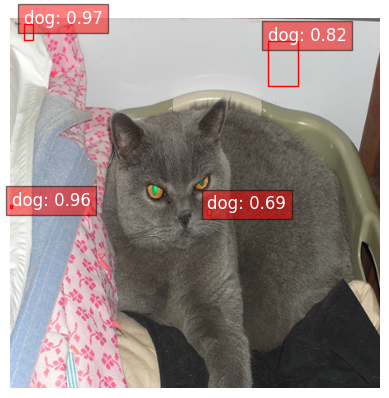

In [21]:
def inference(model, image_path, transform, device, class_to_idx, threshold=0.5):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    original_width, original_height = image.size

    # Resize the image to match the input size expected by the model (e.g., 448 x 448)
    resized_image = image.resize((448, 448))
    resized_width, resized_height = resized_image.size

    # Apply the same transformations used during training
    transformed_image = transform(resized_image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(transformed_image)
        output = output.view(1, 2, 2, 4 + len(class_to_idx))  # Reshape for 2x2 grid

    fig, ax = plt.subplots(1)
    ax.axis("off")
    ax.imshow(resized_image)  # Display resized image

    for grid_y in range(2):
        for grid_x in range(2):
            # Get the class prediction and bounding box for the current grid cell
            class_pred = output[0, grid_y, grid_x, 4:].argmax().item()
            bbox = output[0, grid_y, grid_x, :4].tolist()  # Predicted bbox

            # Confidence (probability of the predicted class)
            confidence = torch.softmax(output[0, grid_y, grid_x, 4:], dim=0)[class_pred].item()

            # Scale the bounding box back to the resized image size
            # Assuming bbox coordinates are normalized to [0, 1] within the grid cell
            x_min = bbox[0] * (resized_width / 2) + grid_x * (resized_width / 2)
            y_min = bbox[1] * (resized_height / 2) + grid_y * (resized_height / 2)
            x_max = bbox[2] * (resized_width / 2) + grid_x * (resized_width / 2)
            y_max = bbox[3] * (resized_height / 2) + grid_y * (resized_height / 2)

            # Draw the bounding box and label on the image if confidence is above threshold
            if confidence > threshold:
                rect = patches.Rectangle(
                    (x_min, y_min),
                    x_max - x_min,
                    y_max - y_min,
                    linewidth=1,
                    edgecolor="r",
                    facecolor="none",
                )
                ax.add_patch(rect)
                plt.text(
                    x_min,
                    y_min,
                    f"{list(class_to_idx.keys())[class_pred]}: {confidence:.2f}",
                    color="white",
                    fontsize=12,
                    bbox=dict(facecolor="red", alpha=0.5),
                )

    plt.show()

# Load the best model
model.load_state_dict(torch.load("best_model.pth"))

# Inference on a sample image
image_path = os.path.join(image_dir, "Cats_Test101.png")
inference(model, image_path, transform, device, class_to_idx, threshold=0.5)